In [1]:
library(dplyr)
library(biomaRt)
library(tximport)
library(stringr)
library(Seurat)
library(harmony)
library(ggplot2)
library(Matrix)
library(fgsea)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: Rcpp



In [2]:
ensembl<-biomaRt::useMart("ensembl",dataset="hsapiens_gene_ensembl")
t2g<-biomaRt::getBM(attributes=c("ensembl_gene_id","external_gene_name"), mart=ensembl)

Ensembl site unresponsive, trying uswest mirror




**Import August data**


In [3]:
setwd("/home/jovyan/data/GCA/MGC/samples_aug2020")

L<-list.files(path = ".")


In [4]:
aug<-read.csv(L[1], sep = '\t', header = FALSE)
colnames(aug)<-c("gene", "count")
names(aug)[2] <- gsub('.gff', '', L[1])

for(i in 2:length(L)){
    b<-read.csv(L[i], sep = '\t', header = FALSE)
    colnames(b)<-c("gene", "attach")
    aug<-cbind(aug,b$attach)
    new_col<-gsub('.gff', '', L[i])
    names(aug)[i+1] <- new_col
}

In [5]:
rownames(aug)<-aug$gene
aug$gene<-NULL

In [6]:
meta_aug<-as.data.frame(str_split_fixed(colnames(aug), "-", n=5))
colnames(meta_aug)<-c("day", "plate", "sort_gate", "cellnum", "cellnum2")

In [7]:
rownames(meta_aug)<-colnames(aug)

In [8]:
meta_aug$sort_gate[meta_aug$sort_gate == "1N"]<-"MonoLMGC"
meta_aug$sort_gate[meta_aug$sort_gate == "2N"]<-"BiLMGC"
meta_aug$sort_gate[meta_aug$sort_gate == "MGC"]<-"MultiLMGC"
meta_aug$sort_gate[meta_aug$sort_gate == "Mac"]<-"MonoMac"
meta_aug$sort_gate[meta_aug$sort_gate == "OC"]<-"MultiOsteo"

In [9]:
meta_aug$plate[meta_aug$plate == "P1"]<-"P5"
meta_aug$plate[meta_aug$plate == "P2"]<-"P6"

In [10]:
meta_aug$run<-"run1"

In [11]:
MGC_aug<-CreateSeuratObject(aug)
MGC_aug<-AddMetaData(MGC_aug, meta_aug)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


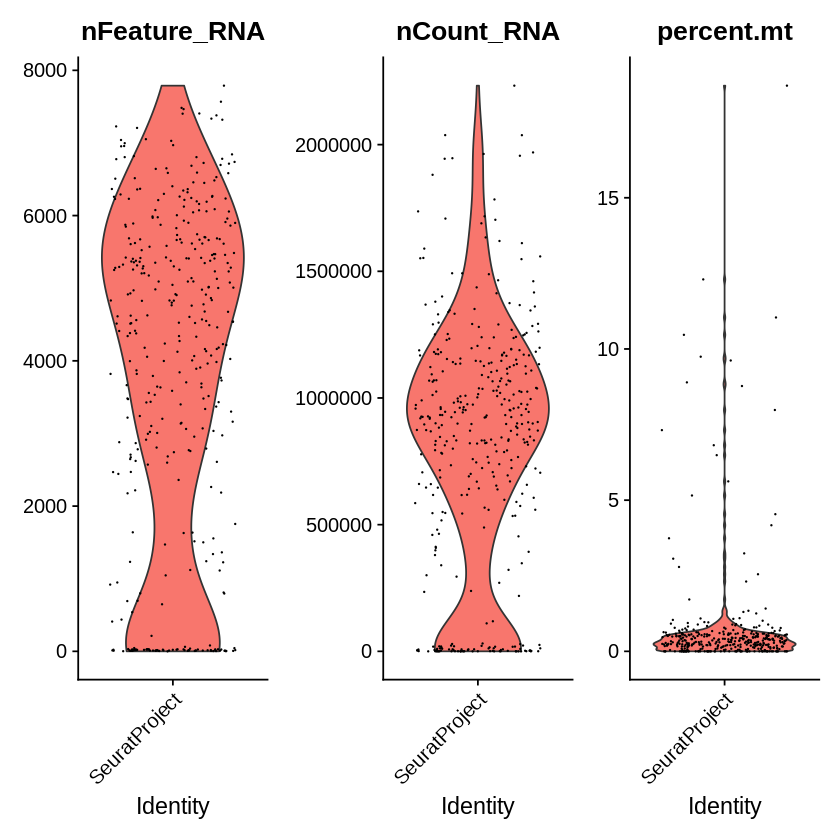

In [12]:
MGC_aug[["percent.mt"]] <- PercentageFeatureSet(MGC_aug, pattern = "^MT-")
VlnPlot(MGC_aug, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [13]:
MGC_aug <- subset(MGC_aug, subset = nFeature_RNA > 400 & percent.mt < 10)

In [14]:
MGC_aug <-  MGC_aug %>% NormalizeData() %>% FindVariableFeatures(selection.method = "vst", nfeatures = 2000) 

In [15]:
setwd("/home/jovyan/data/GCA/MGC/")
saveRDS(MGC_aug, "MGC_aug.RDS")


**Import January data**


In [16]:
setwd("/home/jovyan/data/GCA/MGC/samples_jan2020")

L<-list.files(path = ".")


In [17]:
jan<-read.csv(L[1], sep = '\t', header = FALSE)
colnames(jan)<-c("gene", "count")
names(jan)[2] <- gsub('.gff', '', L[1])

for(i in 2:length(L)){
    b<-read.csv(L[i], sep = '\t', header = FALSE)
    colnames(b)<-c("gene", "attach")
    jan<-cbind(jan,b$attach)
    new_col<-gsub('.gff', '', L[i])
    names(jan)[i+1] <- new_col
}

In [18]:
rownames(jan)<-jan$gene
jan$gene<-NULL

In [19]:
meta_jan<-as.data.frame(str_split_fixed(colnames(jan), "-", n=5))
colnames(meta_jan)<-c("day", "plate", "sort_gate", "cellnum", "cellnum2")

In [20]:
meta_jan$run<-"run2"

In [21]:
rownames(meta_jan)<-colnames(jan)

In [22]:
MGC_jan<-CreateSeuratObject(jan)
MGC_jan<-AddMetaData(MGC_jan, meta_jan)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


Warning message:
“Removed 2 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


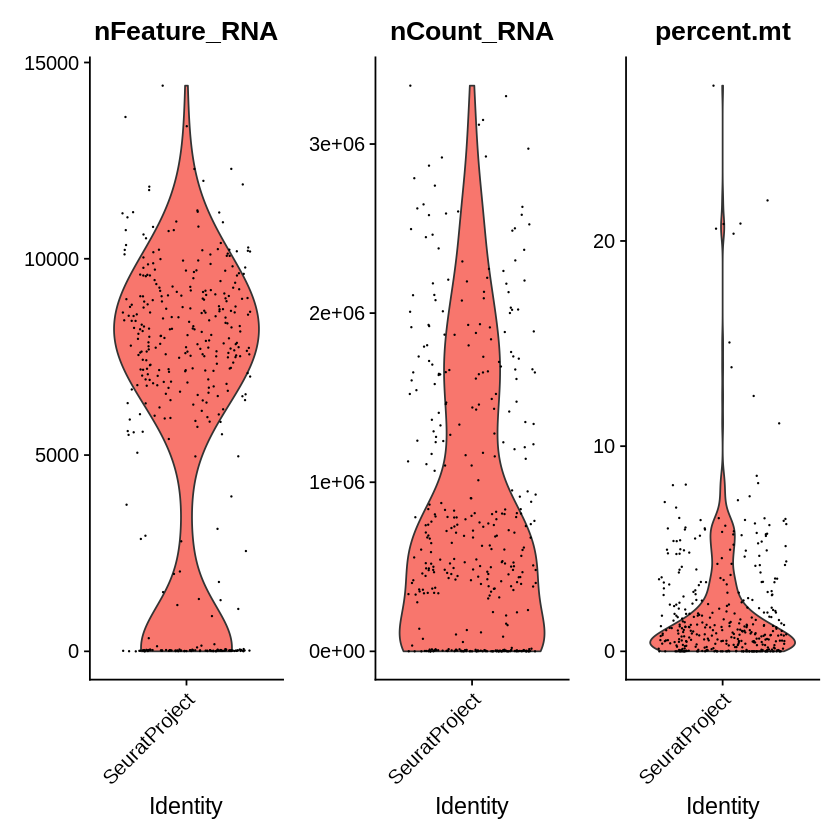

In [23]:
MGC_jan[["percent.mt"]] <- PercentageFeatureSet(MGC_jan, pattern = "^MT-")
VlnPlot(MGC_jan, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [24]:
MGC_jan <- subset(MGC_jan, subset = nFeature_RNA > 400 & percent.mt < 10)

In [25]:
MGC_jan <-  MGC_jan %>% NormalizeData() %>% FindVariableFeatures(selection.method = "vst", nfeatures = 2000) 

In [26]:
setwd("/home/jovyan/data/GCA/MGC/")
saveRDS(MGC_jan, "MGC_jan.RDS")



***Individual analysis***



In [31]:
MGC_jan<- MGC_jan %>% 
NormalizeData() %>% 
FindVariableFeatures(selection.method = "vst", nfeatures = 2000) %>%
ScaleData(verbose = FALSE) %>%
RunPCA(npcs = 20, verbose = FALSE)%>%
RunHarmony('run') %>%
FindNeighbors(dims = 1:20, reduction = 'pca') %>%
FindClusters(resolution = 0.6) %>%
RunUMAP(reduction = "pca", dims = 1:20)

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 282
Number of edges: 9343

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8668
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:39:50 UMAP embedding parameters a = 0.9922 b = 1.112

14:39:50 Read 282 rows and found 20 numeric columns

14:39:50 Using Annoy for neighbor search, n_neighbors = 30

14:39:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:39:50 Writing NN index file to temp file /tmp/RtmpSfACkB/filee62b2af5b7

14:39:50 Searching Annoy index using 1 thread, search_k = 3000

14:39:50 Annoy recall = 100%

14:39:51 Commencing smooth kNN distance calibration using 1 thread

14:39:52 Initializing from n

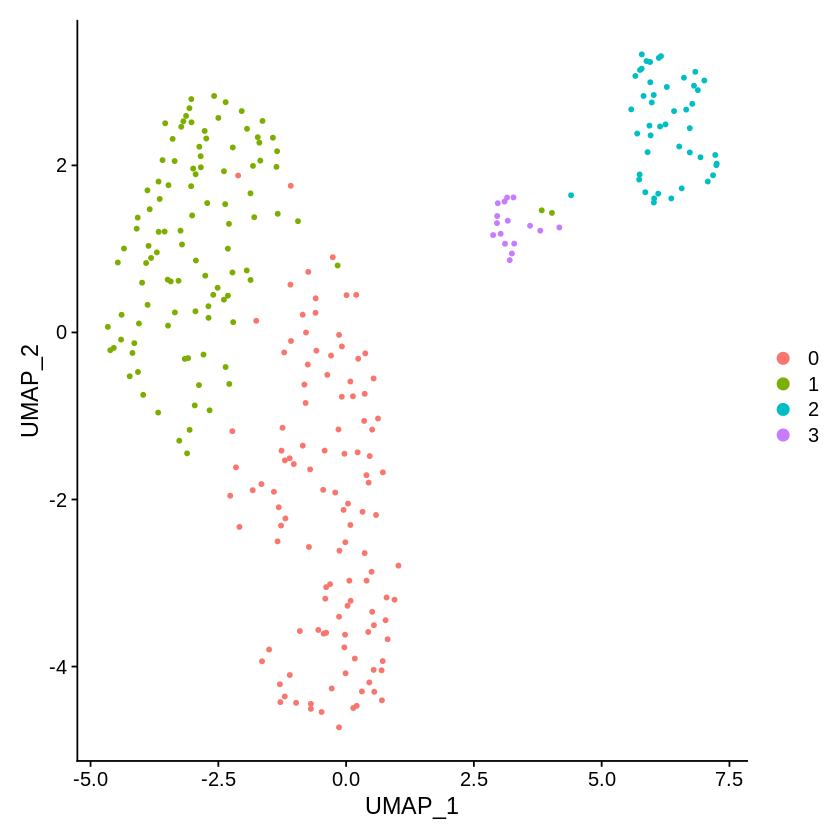

In [62]:
DimPlot(MGC_jan, reduction = 'umap')

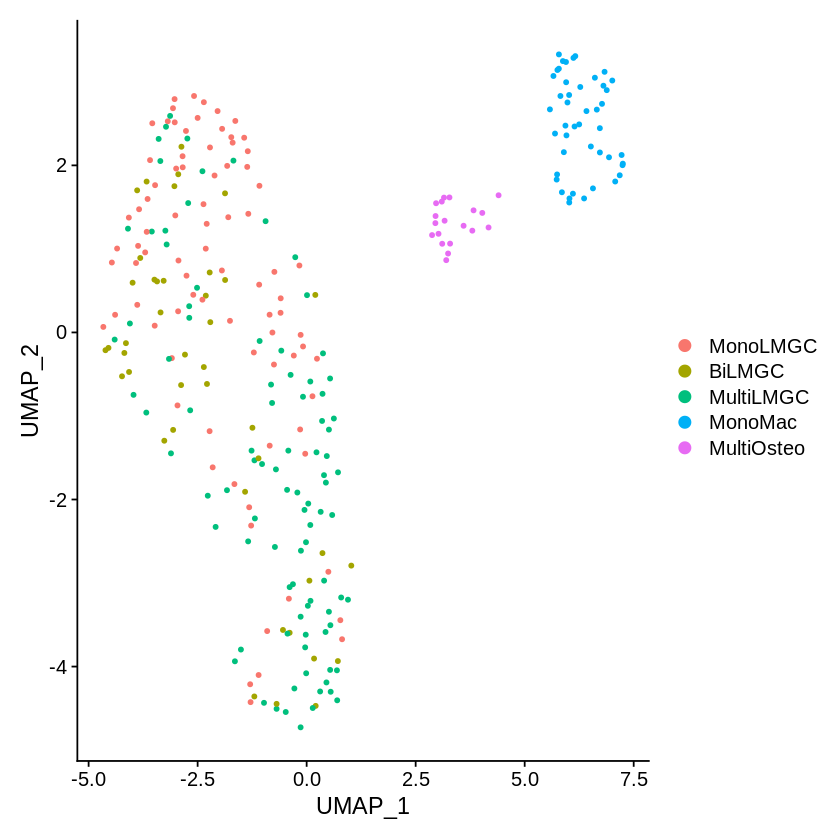

In [63]:
Idents(MGC_jan)<-'sort_gate'
DimPlot(MGC_jan, reduction = 'umap')

In [72]:
meta<-MGC_jan@meta.data
#meta <- meta %>% filter(sort_gate != 'BiLMGC')
meta<- meta %>% dplyr::select(sort_gate, seurat_clusters) 

meta<- meta %>% group_by(seurat_clusters) %>% mutate(total = n())

meta <- meta %>% group_by(seurat_clusters, sort_gate) %>% mutate(per_gate = n())

meta <- meta %>% group_by(seurat_clusters, sort_gate) %>% summarise(props = per_gate/total) %>% unique()

`summarise()` has grouped output by 'seurat_clusters', 'sort_gate'. You can override using the `.groups` argument.



In [73]:
meta$sort_gate <- ordered(meta$sort_gate, levels = c("MultiOsteo", "MonoMac", "MonoLMGC", "BiLMGC", "MultiLMGC"))

Saving 16.9 x 16.9 cm image



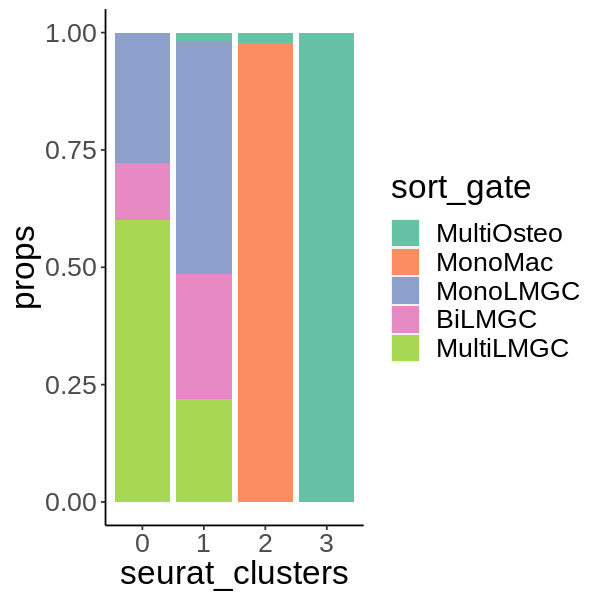

In [74]:
ggplot(meta, aes(x = seurat_clusters, y = props, fill = sort_gate)) + geom_bar(stat = "identity")+ 
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line = element_line(colour = "black"))+
scale_fill_brewer(palette="Set2")+
theme(text = element_text(size=20))+
theme(aspect.ratio = 2/1)


setwd('/home/jovyan/data/GCA/figures')

ggsave("MGC_proportions.png", width = NA,  height = NA,  units = c("cm"),  dpi = 300)

Saving 6.67 x 6.67 in image



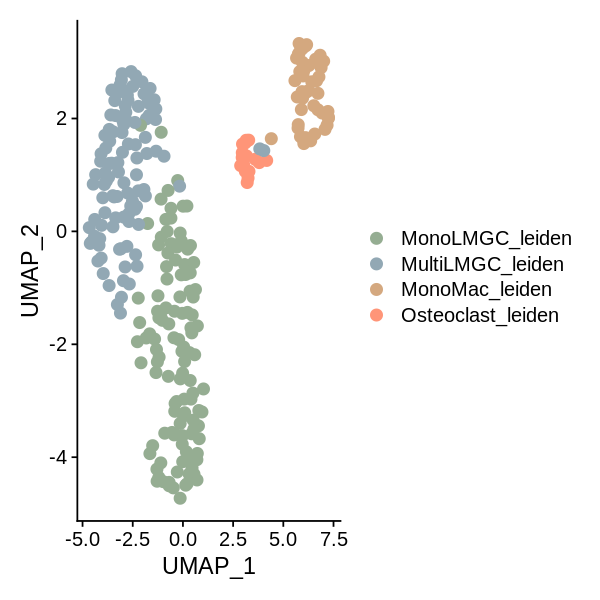

In [78]:
Idents(MGC_jan)<-"seurat_clusters"
new.cluster.ids <- c("MonoLMGC_leiden", "MultiLMGC_leiden", "MonoMac_leiden", "Osteoclast_leiden")
names(new.cluster.ids) <- levels(MGC_jan)
MGC_jan <- RenameIdents(MGC_jan, new.cluster.ids)
MGC_jan[["initial_clustering"]] <- Idents(MGC_jan)
DimPlot(MGC_jan, reduction = "umap", label = FALSE, pt.size = 3, , cols = c("#95ad92", "#92a8b4", "#d4a87f", "#ff9578"))


setwd('/home/jovyan/data/GCA/figures')

ggsave("MGC_UMAP.png", dpi = 300)

In [83]:
LMGC_markers<-FindAllMarkers(MGC_jan, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster MonoLMGC_leiden

Calculating cluster MultiLMGC_leiden

Calculating cluster MonoMac_leiden

Calculating cluster Osteoclast_leiden



In [87]:
setwd("/home/jovyan/data/GCA/MGC/datasets")
saveRDS(MGC_jan, "MGC_jan_processed.RDS")